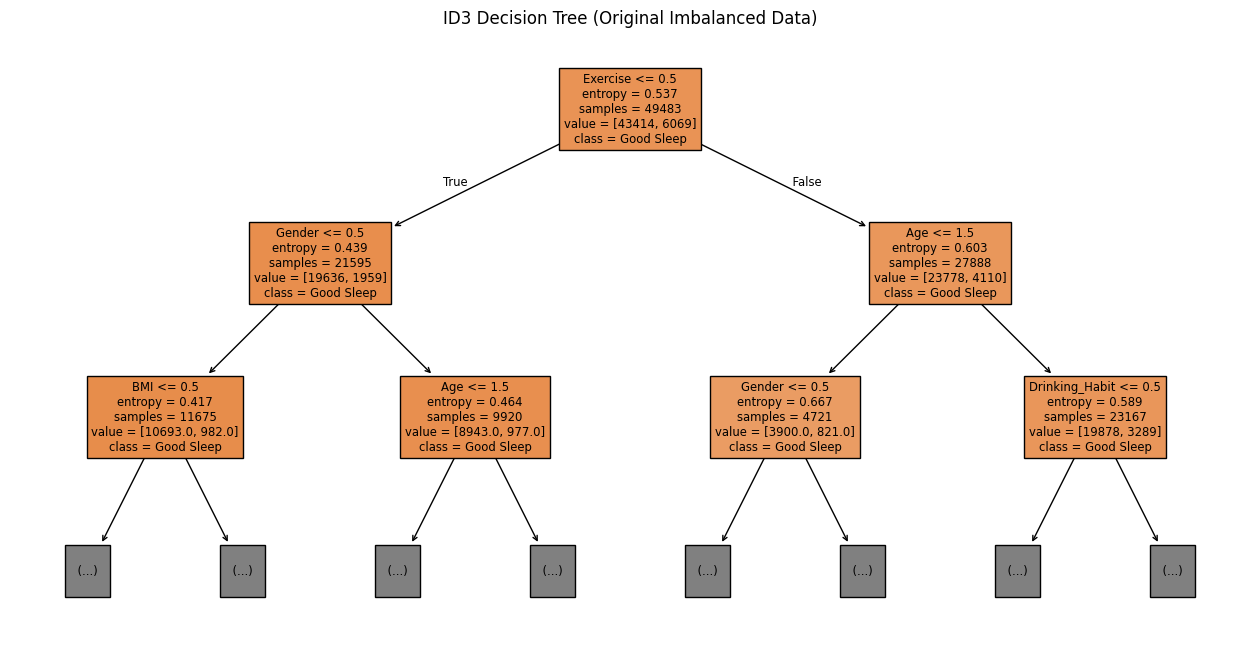

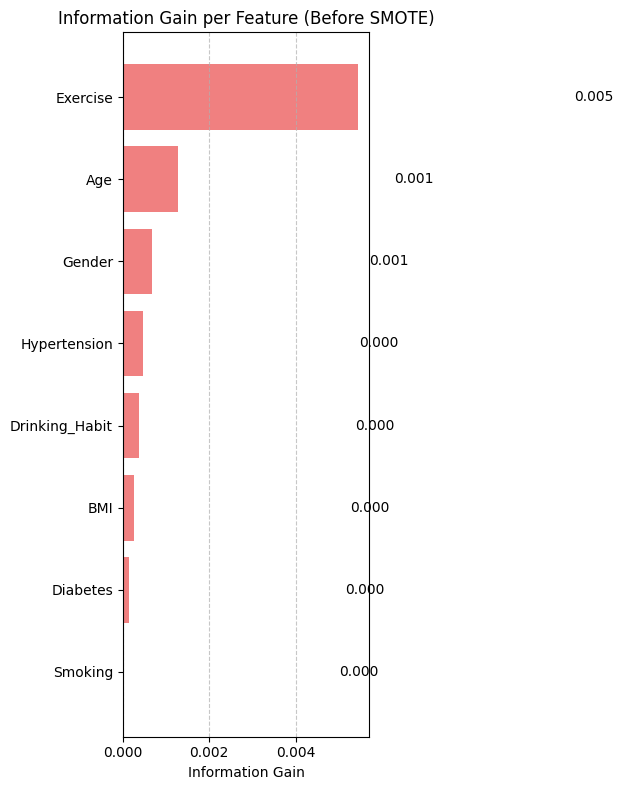

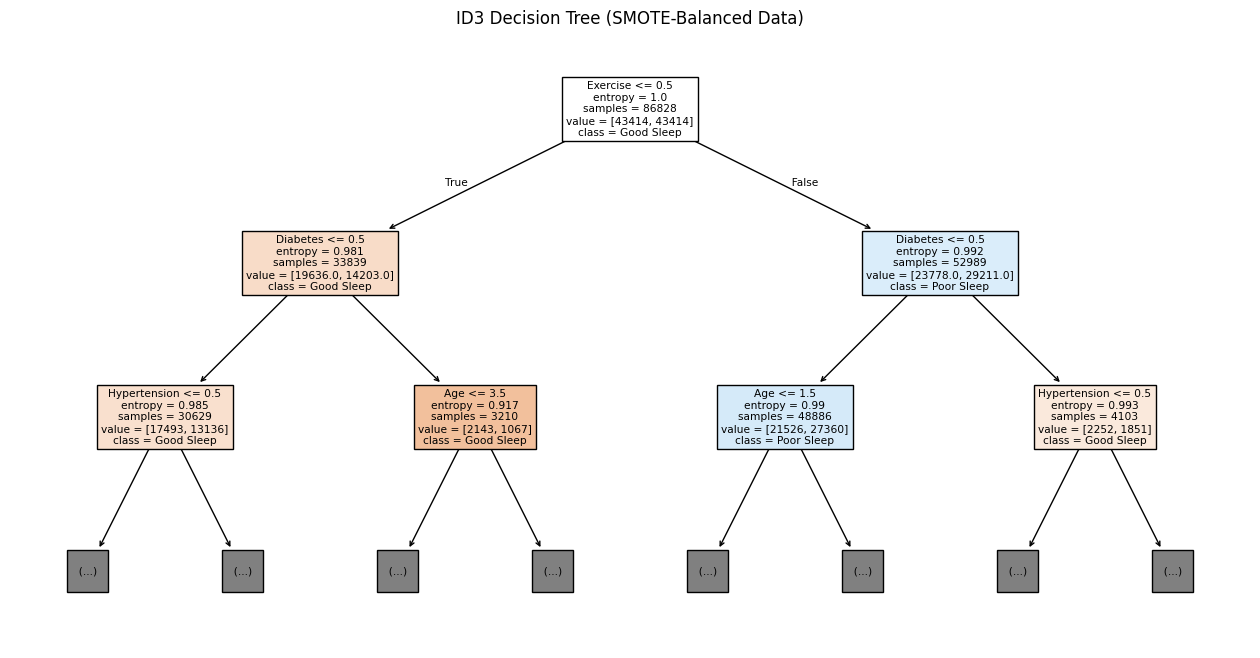

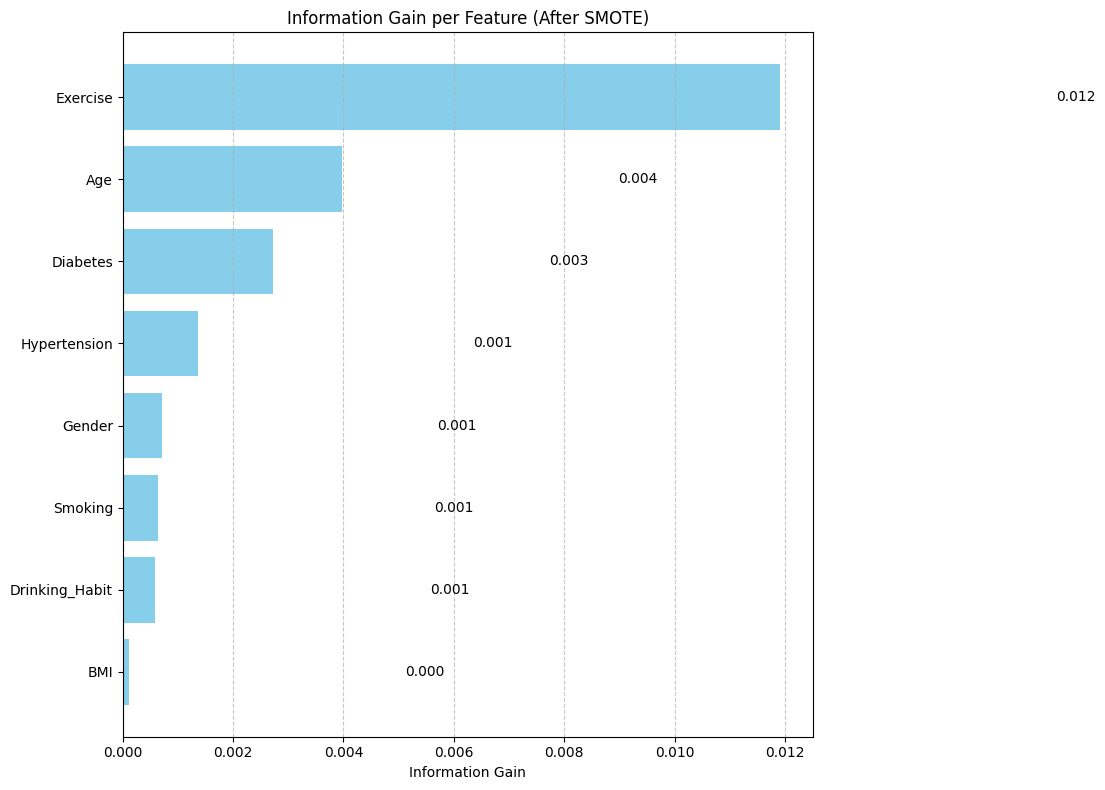

Information Gain Comparison:
       Feature  Information Gain_Unbalanced  Information Gain_SMOTE
      Exercise                     0.005430                0.011914
           Age                     0.001277                0.003970
      Diabetes                     0.000141                0.002723
  Hypertension                     0.000463                0.001356
        Gender                     0.000688                0.000704
       Smoking                     0.000003                0.000646
Drinking_Habit                     0.000370                0.000576
           BMI                     0.000252                0.000113


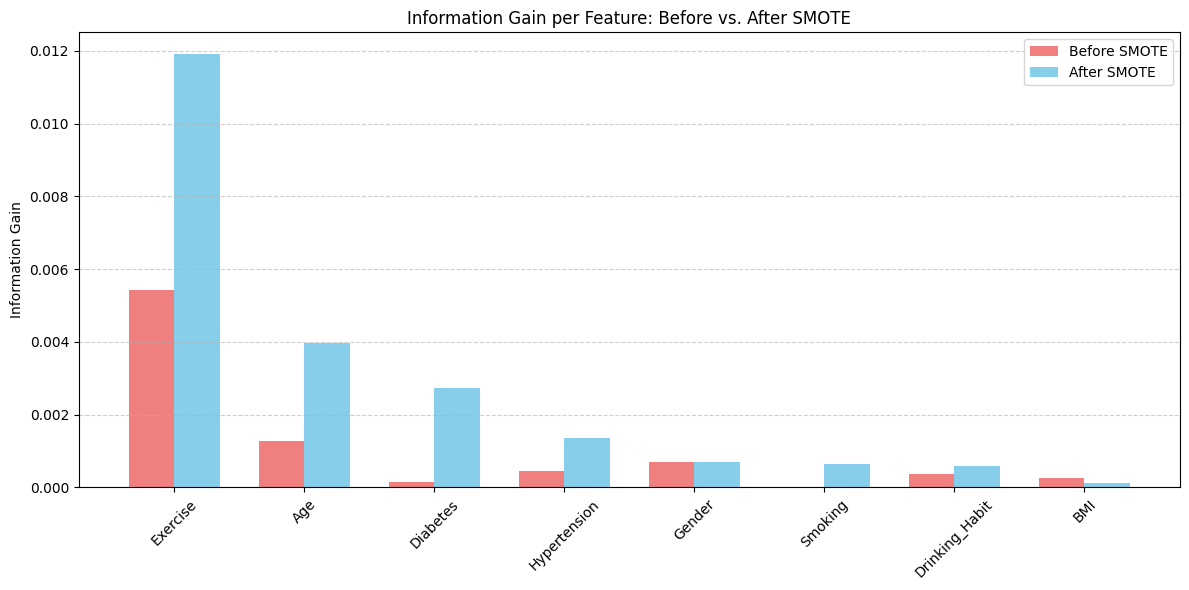

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from math import log2

# --- 1. Load and Prepare the Data ---
df = pd.read_csv("sleep_health.csv").dropna()

df_2015 = pd.DataFrame({
    "Poor_Sleep": df["2015NRS"],
    "Gender": df["gender"],
    "Age": df["2015Age"],
    "BMI": df["2015BMI"],
    "Smoking": df["2015Smoking"],
    "Exercise": df["2015EX"],
    "Diabetes": df["2015Diabetes"],
    "Drinking_Habit": df["2015DrinkHabit"],
    "Hypertension": df["2015Hypertension"]
})

# Bin Age and BMI
df_2015["Age"] = pd.cut(df_2015["Age"], bins=[39, 49, 59, 69, 74], labels=["40–49", "50–59", "60–69", "70–74"])
df_2015["BMI"] = pd.cut(df_2015["BMI"], bins=[0, 18.5, 25, float("inf")], labels=["Underweight", "Normal", "Overweight"])

# Encode all features
le = LabelEncoder()
for col in df_2015.columns:
    df_2015[col] = le.fit_transform(df_2015[col])

# --- 2. Define entropy and info gain ---
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

def info_gain(df, feature, target):
    total_entropy = entropy(df[target])
    values, counts = np.unique(df[feature], return_counts=True)
    weighted_entropy = 0
    for v, count in zip(values, counts):
        subset = df[df[feature] == v]
        weighted_entropy += (count / len(df)) * entropy(subset[target])
    return total_entropy - weighted_entropy

# --- 3. Manual Info Gain BEFORE SMOTE ---
target = "Poor_Sleep"
features = [col for col in df_2015.columns if col != target]

info_gain_dict_unbalanced = {feat: info_gain(df_2015, feat, target) for feat in features}
info_gain_df_unbalanced = pd.DataFrame(info_gain_dict_unbalanced.items(), columns=["Feature", "Information Gain_Unbalanced"])

# --- 4. Train ID3 Tree BEFORE SMOTE ---
X = df_2015[features]
y = df_2015[target]

clf_unbalanced = DecisionTreeClassifier(criterion="entropy", max_depth=8, random_state=42)
clf_unbalanced.fit(X, y)

# Plot Decision Tree (original data)
plt.figure(figsize=(16, 8))
plot_tree(
    clf_unbalanced,
    feature_names=features,
    class_names=["Good Sleep", "Poor Sleep"],
    filled=True,
    max_depth=2
)
plt.title("ID3 Decision Tree (Original Imbalanced Data)")
plt.show()

# --- 5. Horizontal Bar Chart: Info Gain BEFORE SMOTE ---
info_gain_df_unbalanced_sorted = info_gain_df_unbalanced.sort_values("Information Gain_Unbalanced", ascending=True)

plt.figure(figsize=(12, 8))
bars = plt.barh(
    info_gain_df_unbalanced_sorted["Feature"],
    info_gain_df_unbalanced_sorted["Information Gain_Unbalanced"],
    color='lightcoral'
)
plt.xlabel("Information Gain")
plt.title("Information Gain per Feature (Before SMOTE)")
plt.grid(axis="x", linestyle="--", alpha=0.7)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}", va='center', ha='left')

plt.tight_layout()
plt.show()



# --- 6. Apply SMOTE ---
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

df_smote = pd.DataFrame(X_resampled, columns=features)
df_smote["Poor_Sleep"] = y_resampled

# --- 7. Manual Info Gain AFTER SMOTE ---
info_gain_dict_balanced = {feat: info_gain(df_smote, feat, target) for feat in features}
info_gain_df_balanced = pd.DataFrame(info_gain_dict_balanced.items(), columns=["Feature", "Information Gain_SMOTE"])

# --- 8. Train ID3 Tree AFTER SMOTE ---
clf_balanced = DecisionTreeClassifier(criterion="entropy", max_depth=8, random_state=42)
clf_balanced.fit(X_resampled, y_resampled)

# Plot Decision Tree (SMOTE-balanced data)
plt.figure(figsize=(16, 8))
plot_tree(
    clf_balanced,
    feature_names=features,
    class_names=["Good Sleep", "Poor Sleep"],
    filled=True,
    max_depth=2
)
plt.title("ID3 Decision Tree (SMOTE-Balanced Data)")
plt.show()

# --- 9. Horizontal Bar Chart: Info Gain AFTER SMOTE ---
info_gain_df_balanced_sorted = info_gain_df_balanced.sort_values("Information Gain_SMOTE", ascending=True)

plt.figure(figsize=(12, 8))
bars = plt.barh(info_gain_df_balanced_sorted["Feature"], info_gain_df_balanced_sorted["Information Gain_SMOTE"], color='skyblue')
plt.xlabel("Information Gain")
plt.title("Information Gain per Feature (After SMOTE)")
plt.grid(axis="x", linestyle="--", alpha=0.7)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.3f}", va='center', ha='left')

plt.tight_layout()
plt.show()

# --- 10. Compare Info Gain Side-by-Side ---
compare_df = info_gain_df_unbalanced.merge(
    info_gain_df_balanced, on="Feature"
).sort_values("Information Gain_SMOTE", ascending=False)

print("Information Gain Comparison:")
print(compare_df.to_string(index=False))

# --- 11. Side-by-Side Bar Chart ---
x = np.arange(len(compare_df))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, compare_df["Information Gain_Unbalanced"], width, label="Before SMOTE", color="lightcoral")
plt.bar(x + width/2, compare_df["Information Gain_SMOTE"], width, label="After SMOTE", color="skyblue")
plt.xticks(ticks=x, labels=compare_df["Feature"], rotation=45)
plt.ylabel("Information Gain")
plt.title("Information Gain per Feature: Before vs. After SMOTE")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()